In [1]:
from src.CLIP import CLIP, text_encoder, image_encoder
import torch
from src.io import Image_Text_Dataset_Inference
from src.Trainer import train_clip
import numpy as np
from torch.utils.data import DataLoader, random_split, ConcatDataset
from transformers import CLIPTokenizer as HFCLIPTokenizer
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
illustris_tng_100_dataset1 = Image_Text_Dataset_Inference(fits_file='/d1/manth145/UVCANDELS/synthetic_images/hlsp_illustris_hst_acs_tng100-7-6-yxz_f814w_v1_sim.fits', cutout_size=64)

/home/manth145/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28123/28123 [00:09<00:00, 2909.64it/s]


Found 28123 images with no NaNs


In [4]:
train_val_split = 0.9
batch_size = 32
nworkers = 6

dataloader = DataLoader(illustris_tng_100_dataset1, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=nworkers, persistent_workers=True)

In [5]:
model = CLIP(embed_dim=128, temperature=0.1, vocab_size=50000).to(device)

/home/manth145/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/manth145/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


50000


In [6]:
model.load_state_dict(torch.load('./checkpoints/clip_checkpoint_epoch_45.pt')['model_state_dict'])

<All keys matched successfully>

In [7]:
tokenizer = HFCLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

/home/manth145/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
image, condition, condition_text = next(iter(dataloader))
which_image_index = 10

In [9]:
text_inputs = []
random_subset = np.random.choice(illustris_tng_100_dataset1.subset,2000)
for each in random_subset:
    text_inputs.append(f"(P1:{np.round(each['Inferred z'],3)}), (P2:{np.round(np.log10(each['Stellar mass w2sr']), 3)})")

In [10]:
text_tokenized = torch.from_numpy(np.array([tokenizer(iii, padding="max_length", max_length = 64, truncation=True)['input_ids'] for iii in text_inputs])).to(device)

In [11]:
with torch.no_grad():
    image_features = model.encode_image(torch.unsqueeze(image[which_image_index], dim=0).to(device))
    text_features = model.encode_text(text_tokenized)


In [12]:
#Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

In [13]:
# indices, values

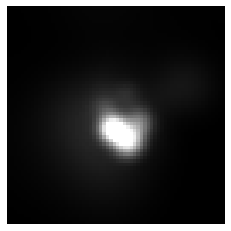


Top predictions:(P1:2.953), (P2:8.113)

(P1:1.825), (P2:8.281): 23.94%
(P1:1.653), (P2:8.258): 16.00%
(P1:1.658), (P2:8.256): 14.05%
(P1:1.922), (P2:8.25): 8.11%
(P1:1.851), (P2:8.27): 7.54%


In [16]:
plt.figure()

plt.imshow(image[which_image_index,0,:,:].cpu().numpy(), cmap='gray', origin='lower')

plt.axis('off')
plt.show()

print(f"\nTop predictions:{condition_text[which_image_index]}\n")
for value, index in zip(values, indices):
    print(f"{text_inputs[index]}: {100 * value.item():.2f}%")

'(P1:2.512), (P2:8.293)'

In [18]:
-2 * torch.rand(10) + 3

tensor([1.4498, 1.3076, 2.5294, 1.5108, 1.8969, 2.9379, 2.8667, 1.6940, 1.8362,
        2.6641])

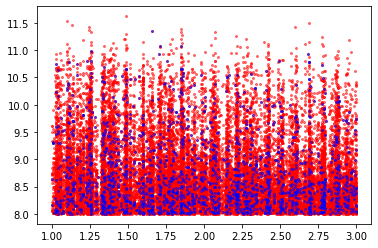

In [15]:
plt.figure()

plt.scatter(illustris_tng_100_dataset1.subset['Inferred z'], np.log10(illustris_tng_100_dataset1.subset['Stellar mass w2sr']), s=4, color='red', alpha=0.5)
plt.scatter(random_subset['Inferred z'], np.log10(random_subset['Stellar mass w2sr']), s=4, color='blue', alpha=0.5)


plt.show()

In [20]:
image_features.shape

torch.Size([1, 128])